In [1]:
#step 1: importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#models from Scikit Learn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,accuracy_score,precision_score, recall_score


In [2]:
# step 2:  loading data from MIMIC IV csv to dataframe
pnts = pd.read_csv("patients.csv")
#admissions = pd.read_csv("admissions.csv")
diag_icd = pd.read_csv("diagnoses_icd.csv")
diag_dict = pd.read_csv("d_icd_diagnoses.csv")
prescriptions = pd.read_csv("prescriptions.csv")

/var/folders/8s/rjjqh8m12hggt98w3x81db0m0000gn/T/ipykernel_47570/38197142.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv("prescriptions.csv")


In [3]:
#step 3: Data Processing
#Select pnts with respiratory related dignosis in their medical history ; by merging diagnosis dictionary list with pnts diagnosis data
#J00–J99 are considered to be " Diseases of the respiratory system"
merged_icd10 = diag_icd.merge(diag_dict, on=['icd_code', 'icd_version'])
respiratory_therapy_icds = merged_icd10[(merged_icd10['icd_version'] == 10) & (merged_icd10['icd_code'].str.startswith('J'))]

respiratory_therapy_icds

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
756,10001843,26133978,2,J9601,10,Acute respiratory failure with hypoxia
758,10001843,26133978,4,J189,10,"Pneumonia, unspecified organism"
759,10001843,26133978,5,J9602,10,Acute respiratory failure with hypercapnia
765,10001843,26133978,11,J440,10,Chronic obstructive pulmonary disease with (ac...
771,10001843,26133978,17,J441,10,Chronic obstructive pulmonary disease with (ac...
...,...,...,...,...,...,...
6364281,19999784,24935234,9,J3801,10,"Paralysis of vocal cords and larynx, unilateral"
6364305,19999784,25715748,4,J3800,10,"Paralysis of vocal cords and larynx, unspecified"
6364322,19999784,26194817,3,J3801,10,"Paralysis of vocal cords and larynx, unilateral"
6364426,19999828,25744818,10,J449,10,"Chronic obstructive pulmonary disease, unspeci..."


In [4]:
#merge above selected ICD list with patient to get patient details and then join with RX table to get the features needed

# Patients unique list who got diagnosised under respiratory disease therapy
target_icd_pnts=respiratory_therapy_icds['subject_id'].unique()
#print(target_icd_pnts.size)

# joining with above ICD list for resporiatory therapy
target_icd_pnts=respiratory_therapy_icds.merge(pnts, on="subject_id", how="inner")
target_icd_pnts_1 = target_icd_pnts[[
    'subject_id', 'hadm_id', 'icd_code','icd_version', 'long_title',  
    'gender', 'anchor_age']] 
# print(target_icd_pnts_1.head)

#joining with prescriptions — using subject_id + hadm_id
target_icd_pnts_rx= target_icd_pnts_1.merge(prescriptions, on=['subject_id', 'hadm_id'],how="inner")
# contains Pnt with ICD for resporiatory thereapy  and all the RX details
target_icd_pnts_rx

,subject_id,hadm_id,icd_code,icd_version,long_title,gender,anchor_age,pharmacy_id,poe_id,poe_seq,...,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10001843,26133978,J9601,10,Acute respiratory failure with hypoxia,M,73,310234,10001843-248,248.0,...,001187,3.380117e+08,Floor Stock Bag,NaN,1000,mL,1000,mL,1.0,IV
1,10001843,26133978,J9601,10,Acute respiratory failure with hypoxia,M,73,1917871,10001843-233,233.0,...,NaN,0.000000e+00,50 mL Bag,NaN,150,mL,150,mL,NaN,IV
2,10001843,26133978,J9601,10,Acute respiratory failure with hypoxia,M,73,1917871,10001843-233,233.0,...,045309,3.380703e+08,20mEq/50mL Premix,NaN,60,mEq,150,mL,NaN,IV
3,10001843,26133978,J9601,10,Acute respiratory failure with hypoxia,M,73,3383833,10001843-233,233.0,...,NaN,0.000000e+00,50 mL Bag,NaN,100,mL,100,mL,NaN,IV
4,10001843,26133978,J9601,10,Acute respiratory failure with hypoxia,M,73,3383833,10001843-233,233.0,...,045309,3.380703e+08,20mEq/50mL Premix,NaN,40,mEq,100,mL,NaN,IV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611126,19999828,29734428,J449,10,"Chronic obstructive pulmonary disease, unspeci...",F,46,94231471,19999828-185,185.0,...,347.0,5.107903e+10,0.2mg Tablet,NaN,0.2,mg,1,TAB,3.0,PO
11611127,19999828,29734428,J449,10,"Chronic obstructive pulmonary disease, unspeci...",F,46,94922746,19999828-181,181.0,...,4225.0,9.046445e+08,5mg Tablet,NaN,5-10,mg,1-2,TAB,NaN,PO/NG
11611128,19999828,29734428,J449,10,"Chronic obstructive pulmonary disease, unspeci...",F,46,95948868,19999828-176,176.0,...,17205.0,5.107909e+10,120 mg ER Cap,NaN,120,mg,1,CAP,1.0,PO
11611129,19999828,29734428,J449,10,"Chronic obstructive pulmonary disease, unspeci...",F,46,96369302,19999828-178,178.0,...,17037.0,9.045853e+08,10mg Tablet,NaN,10,mg,1,TAB,1.0,PO


In [5]:
#list of respiratory-related drugs; need to susbet our above pnts data with only the RX that are related to resporiatroy issues
respiratory_drugs = [
    'albuterol', 'ventolin', 'ipratropium', 'duoneb',
    'fluticasone', 'salmeterol', 'formoterol', 'budesonide',
    'advair', 'symbicort', 'montelukast', 'singulair',
    'prednisone', 'methylprednisolone', 'solu-medrol',
    'theophylline', 'asmanex', 'ciclesonide', 'beclomethasone',
    'mometasone', 'xolair', 'omalizumab', 'dupixent', 'dupilumab',
    'nucala', 'mepolizumab', 'benralizumab', 'fasenra',
    'tezspire', 'tezepelumab'
]

#converting the drug names to lowercase for matcing
target_icd_pnts_rx['drug_lower'] = target_icd_pnts_rx['drug'].str.lower()

#selecting respiratory rx records
respiratory_rx_final = target_icd_pnts_rx[target_icd_pnts_rx['drug_lower'].isin(respiratory_drugs)]
respiratory_rx_final

,subject_id,hadm_id,icd_code,icd_version,long_title,gender,anchor_age,pharmacy_id,poe_id,poe_seq,...,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route,drug_lower
541,10001884,24746267,J441,10,Chronic obstructive pulmonary disease with (ac...,F,68,2200947,10001884-1436,1436.0,...,4.999900e+10,20 mg Tablet,NaN,40,mg,2,TAB,1.0,PO/NG,prednisone
547,10001884,24746267,J441,10,Chronic obstructive pulmonary disease with (ac...,F,68,21486403,10001884-1429,1429.0,...,5.400172e+07,10 mg Tablet,NaN,30,mg,3,TAB,1.0,PO/NG,prednisone
571,10001884,24746267,J441,10,Chronic obstructive pulmonary disease with (ac...,F,68,76848695,10001884-1437,1437.0,...,5.400172e+07,10 mg Tablet,NaN,10,mg,1,TAB,1.0,PO/NG,prednisone
583,10001884,24746267,J45909,10,"Unspecified asthma, uncomplicated",F,68,2200947,10001884-1436,1436.0,...,4.999900e+10,20 mg Tablet,NaN,40,mg,2,TAB,1.0,PO/NG,prednisone
589,10001884,24746267,J45909,10,"Unspecified asthma, uncomplicated",F,68,21486403,10001884-1429,1429.0,...,5.400172e+07,10 mg Tablet,NaN,30,mg,3,TAB,1.0,PO/NG,prednisone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11605581,19994218,27325077,J45991,10,Cough variant asthma,M,69,52279585,19994218-549,549.0,...,6.373905e+10,10 mg Tablet,NaN,15,mg,1.5,TAB,2.0,PO,prednisone
11605609,19994218,27325077,J45991,10,Cough variant asthma,M,69,61870302,19994218-536,536.0,...,6.373905e+10,10 mg Tablet,NaN,10,mg,1,TAB,2.0,PO/NG,prednisone
11605621,19994218,27325077,J45991,10,Cough variant asthma,M,69,64856904,19994218-547,547.0,...,5.400192e+07,50 mg Tablet,NaN,50,mg,1,TAB,1.0,PO,prednisone
11605674,19994218,27325077,J45991,10,Cough variant asthma,M,69,81015943,19994218-476,476.0,...,6.516208e+10,3mg Capsule,NaN,3,mg,1,CAP,3.0,PO,budesonide


In [6]:
#ICD-10 codes for adverse events (T36-T50, Y40-Y59, Z88-Z92)
ae_diag = diag_icd[
    (diag_icd['icd_version'] == 10) &
    (
        diag_icd['icd_code'].str.startswith('T') |
        diag_icd['icd_code'].str.startswith('Y4') |
        diag_icd['icd_code'].str.startswith('Z88') |
        diag_icd['icd_code'].isin(['Z91.0', 'Z92.2', 'Z92.6'])
    )
]

#assigning ae_label = 1 if adverse event happened over the history of treatment , else 0
respiratory_rx_final['ae_label'] = respiratory_rx_final['hadm_id'].isin(ae_diag['hadm_id']).astype(int)
respiratory_rx_final

/var/folders/8s/rjjqh8m12hggt98w3x81db0m0000gn/T/ipykernel_47570/2033688215.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respiratory_rx_final['ae_label'] = respiratory_rx_final['hadm_id'].isin(ae_diag['hadm_id']).astype(int)


,subject_id,hadm_id,icd_code,icd_version,long_title,gender,anchor_age,pharmacy_id,poe_id,poe_seq,...,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route,drug_lower,ae_label
541,10001884,24746267,J441,10,Chronic obstructive pulmonary disease with (ac...,F,68,2200947,10001884-1436,1436.0,...,20 mg Tablet,NaN,40,mg,2,TAB,1.0,PO/NG,prednisone,0
547,10001884,24746267,J441,10,Chronic obstructive pulmonary disease with (ac...,F,68,21486403,10001884-1429,1429.0,...,10 mg Tablet,NaN,30,mg,3,TAB,1.0,PO/NG,prednisone,0
571,10001884,24746267,J441,10,Chronic obstructive pulmonary disease with (ac...,F,68,76848695,10001884-1437,1437.0,...,10 mg Tablet,NaN,10,mg,1,TAB,1.0,PO/NG,prednisone,0
583,10001884,24746267,J45909,10,"Unspecified asthma, uncomplicated",F,68,2200947,10001884-1436,1436.0,...,20 mg Tablet,NaN,40,mg,2,TAB,1.0,PO/NG,prednisone,0
589,10001884,24746267,J45909,10,"Unspecified asthma, uncomplicated",F,68,21486403,10001884-1429,1429.0,...,10 mg Tablet,NaN,30,mg,3,TAB,1.0,PO/NG,prednisone,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11605581,19994218,27325077,J45991,10,Cough variant asthma,M,69,52279585,19994218-549,549.0,...,10 mg Tablet,NaN,15,mg,1.5,TAB,2.0,PO,prednisone,1
11605609,19994218,27325077,J45991,10,Cough variant asthma,M,69,61870302,19994218-536,536.0,...,10 mg Tablet,NaN,10,mg,1,TAB,2.0,PO/NG,prednisone,1
11605621,19994218,27325077,J45991,10,Cough variant asthma,M,69,64856904,19994218-547,547.0,...,50 mg Tablet,NaN,50,mg,1,TAB,1.0,PO,prednisone,1
11605674,19994218,27325077,J45991,10,Cough variant asthma,M,69,81015943,19994218-476,476.0,...,3mg Capsule,NaN,3,mg,1,CAP,3.0,PO,budesonide,1


In [7]:
respiratory_rx_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85354 entries, 541 to 11605700
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         85354 non-null  int64  
 1   hadm_id            85354 non-null  int64  
 2   icd_code           85354 non-null  object 
 3   icd_version        85354 non-null  int64  
 4   long_title         85354 non-null  object 
 5   gender             85354 non-null  object 
 6   anchor_age         85354 non-null  int64  
 7   pharmacy_id        85354 non-null  int64  
 8   poe_id             83919 non-null  object 
 9   poe_seq            83919 non-null  float64
 10  order_provider_id  85304 non-null  object 
 11  starttime          84481 non-null  object 
 12  stoptime           84528 non-null  object 
 13  drug_type          85354 non-null  object 
 14  drug               85354 non-null  object 
 15  formulary_drug_cd  84718 non-null  object 
 16  gsn                853

In [8]:

#Step:5 Feature Engineering
# for each pnts admission consider every single drug as unique record
drug_count = respiratory_rx_final.groupby(['subject_id', 'hadm_id'])['drug'].nunique().reset_index(name='n_unique_drugs')

# Gender encode as 0 for Male and 1 for Female
respiratory_rx_final['gender'] = respiratory_rx_final['gender'].map({'M': 0, 'F': 1}).fillna(0)

# Merge drug count
respiratory_rx_final = respiratory_rx_final.merge(drug_count, on=['subject_id', 'hadm_id'])
respiratory_rx_final

/var/folders/8s/rjjqh8m12hggt98w3x81db0m0000gn/T/ipykernel_47570/2527447163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respiratory_rx_final['gender'] = respiratory_rx_final['gender'].map({'M': 0, 'F': 1}).fillna(0)


,subject_id,hadm_id,icd_code,icd_version,long_title,gender,anchor_age,pharmacy_id,poe_id,poe_seq,...,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route,drug_lower,ae_label,n_unique_drugs
0,10001884,24746267,J441,10,Chronic obstructive pulmonary disease with (ac...,1,68,2200947,10001884-1436,1436.0,...,NaN,40,mg,2,TAB,1.0,PO/NG,prednisone,0,1
1,10001884,24746267,J441,10,Chronic obstructive pulmonary disease with (ac...,1,68,21486403,10001884-1429,1429.0,...,NaN,30,mg,3,TAB,1.0,PO/NG,prednisone,0,1
2,10001884,24746267,J441,10,Chronic obstructive pulmonary disease with (ac...,1,68,76848695,10001884-1437,1437.0,...,NaN,10,mg,1,TAB,1.0,PO/NG,prednisone,0,1
3,10001884,24746267,J45909,10,"Unspecified asthma, uncomplicated",1,68,2200947,10001884-1436,1436.0,...,NaN,40,mg,2,TAB,1.0,PO/NG,prednisone,0,1
4,10001884,24746267,J45909,10,"Unspecified asthma, uncomplicated",1,68,21486403,10001884-1429,1429.0,...,NaN,30,mg,3,TAB,1.0,PO/NG,prednisone,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85349,19994218,27325077,J45991,10,Cough variant asthma,0,69,52279585,19994218-549,549.0,...,NaN,15,mg,1.5,TAB,2.0,PO,prednisone,1,2
85350,19994218,27325077,J45991,10,Cough variant asthma,0,69,61870302,19994218-536,536.0,...,NaN,10,mg,1,TAB,2.0,PO/NG,prednisone,1,2
85351,19994218,27325077,J45991,10,Cough variant asthma,0,69,64856904,19994218-547,547.0,...,NaN,50,mg,1,TAB,1.0,PO,prednisone,1,2
85352,19994218,27325077,J45991,10,Cough variant asthma,0,69,81015943,19994218-476,476.0,...,NaN,3,mg,1,CAP,3.0,PO,budesonide,1,2


In [9]:

# step6 : Feature data processing

features = respiratory_rx_final[['subject_id', 'hadm_id', 'anchor_age', 'gender', 'dose_val_rx','prod_strength','n_unique_drugs','poe_seq', 'ndc','doses_per_24_hrs','ae_label']].drop_duplicates()
def clean_dose(val):
    try:
        # Handle ranges like "2-4"
        if '-' in str(val):
            parts = val.split('-')
            return (float(parts[0]) + float(parts[1])) / 2  # Average the range
        return float(val)
    except:
        return np.nan  # Invalid entry becomes NaN

features['dose_val_rx'] = features['dose_val_rx'].apply(clean_dose)

cols_to_fill = ['doses_per_24_hrs', 'dose_val_rx', 'prod_strength', 'poe_seq', 'ndc']
features[cols_to_fill] = features[cols_to_fill].fillna(0)


X = features[['anchor_age', 'gender', 'dose_val_rx','n_unique_drugs','poe_seq','ndc','doses_per_24_hrs']]
y = features['ae_label']

#remove any NaN in the data
nan_columns = features.isnull().sum()
nan_columns = nan_columns[nan_columns > 0]
print(nan_columns)


Series([], dtype: int64)


In [10]:
#step 7 Training & Testing split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=100)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=100)

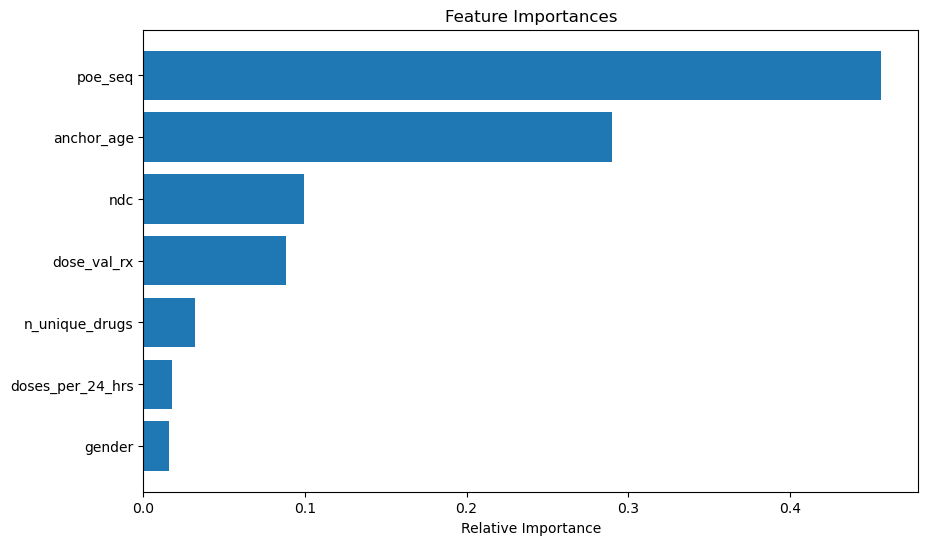

In [11]:
#features important analysis
importances = model.feature_importances_
indices = np.argsort(importances) 

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [35]:
# try to fit model for most of classifier models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=1000, random_state=42),
    'Decision Tree':DecisionTreeClassifier(max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'Extra Trees': ExtraTreesClassifier(n_estimators=1000, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(64, 32),activation='relu',solver='adam', max_iter=300, random_state=42),
    'SVM': SVC(probability=True),
     'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []

for name, model in models.items():
    print(f"\n {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': auc,
        'Precision': precision,
        'Recall': recall
    })





 Logistic Regression...
Accuracy: 0.5474
ROC AUC: 0.5077
Precision: 0.3594
Recall: 0.0069

 Random Forest...
Accuracy: 0.7236
ROC AUC: 0.7902
Precision: 0.7128
Recall: 0.6465

 Decision Tree...
Accuracy: 0.6163
ROC AUC: 0.6504
Precision: 0.5727
Recall: 0.5813

 Gradient Boosting...
Accuracy: 0.6473
ROC AUC: 0.6874
Precision: 0.6365
Recall: 0.5047

 KNN...
Accuracy: 0.6065
ROC AUC: 0.6345
Precision: 0.5688
Recall: 0.5204

 Extra Trees...
Accuracy: 0.7253
ROC AUC: 0.7932
Precision: 0.7046
Recall: 0.6710

 MLP...
Accuracy: 0.4510
ROC AUC: 0.5017
Precision: 0.4505
Recall: 0.9994

 SVM...
Accuracy: 0.5499
ROC AUC: 0.5798
Precision: 0.0000
Recall: 0.0000

 XGBoost...
Accuracy: 0.6954
ROC AUC: 0.7551
Precision: 0.6870
Recall: 0.5937


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [37]:
# Show comparison
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print("\n Model Comparison:")
print(results_df)



 Model Comparison:
                 Model  Accuracy   ROC AUC  Precision    Recall
5          Extra Trees  0.725272  0.793175   0.704596  0.670993
1        Random Forest  0.723641  0.790235   0.712812  0.646544
8              XGBoost  0.695380  0.755119   0.687042  0.593722
3    Gradient Boosting  0.647283  0.687442   0.636467  0.504679
2        Decision Tree  0.616304  0.650383   0.572703  0.581346
4                  KNN  0.606522  0.634539   0.568789  0.520374
7                  SVM  0.549864  0.579790   0.000000  0.000000
0  Logistic Regression  0.547418  0.507712   0.359375  0.006942
6                  MLP  0.450951  0.501731   0.450476  0.999396


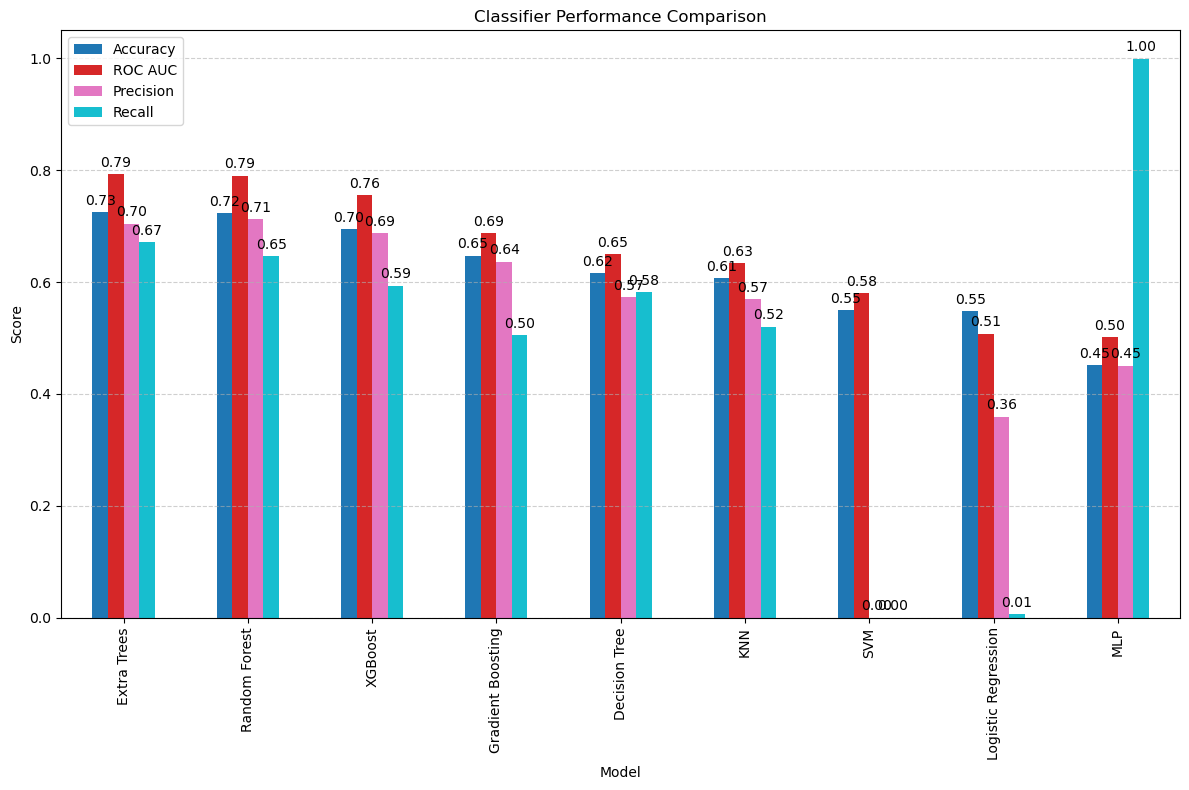

In [39]:
# Set index to Model
results_df_plot = results_df.set_index('Model')[['Accuracy', 'ROC AUC', 'Precision', 'Recall']]

#  bar plot
ax = results_df_plot.plot(kind='bar', figsize=(12, 8), colormap='tab10')
plt.title('Classifier Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.ylim(0, 1.05)
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)

#displaying values on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()
